In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

In [2]:
# Setup your PBSCluster

project = 'P93300641' #input your project code
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [3]:
client.cluster

In [9]:
def get_files(exp):
    d='/glade/scratch/djk2120/PPEn11/amflx_lhc/hist/'+exp+'/*.nc'
    files = sorted(glob.glob(d))
    return files

In [104]:
def get_ds(exp,dvs=[]):
    files=get_files(exp)

    def preprocess(ds,singles=False):
        nt = len(ds.time)
        ix = np.arange(nt)<nt-1 #first timestep is not meaningful
        if singles:
            onecopy  = ['RAIN','SNOW','FSDS','mcsec','TLAI','TSA','RH2M']
            ds2 = ds[onecopy].shift(time=-1).isel(time=ix,lndgrid=0)
        else:
            if len(dvs)==0:
                tmp = xr.open_dataset(files[0])
                i=0
                for v in tmp.data_vars:
                    if 'time' in tmp[v].dims:
                        i+=1
                        if i>8:
                            dvs.append(v)
            ds2 = ds[dvs].shift(time=-1).isel(time=ix,lndgrid=0)
        return ds2

    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,
                           preprocess=preprocess)
    ds0 = preprocess(xr.open_dataset(files[0]),singles=True)
    for v in ds0.data_vars:
        ds[v]=ds0[v]
    
    params=['kmax','psi50']
    def preprocess(ds):
        return ds[params].isel(pft=1,segment=0)
    keys=[f.split('beta3_')[1].split('.')[0] for f in files]
    pfiles=['/glade/scratch/djk2120/PPEn11/amflx_lhc/paramfiles/'+key+'.nc' for key in keys]
    ps = xr.open_mfdataset(pfiles,combine='nested',concat_dim='ens',parallel=True,
                           preprocess=preprocess)

    for p in params:
        ds[p]=ps[p].drop(['pftname','segment'])

    return ds

### START HERE

In [146]:
%%time
exp='CTL2010SP'
dvs=['FPSN','EFLX_LH_TOT','SOILWATER_10CM']
ds=get_ds(exp,dvs)

CPU times: user 3.06 s, sys: 1.29 s, total: 4.35 s
Wall time: 8.94 s


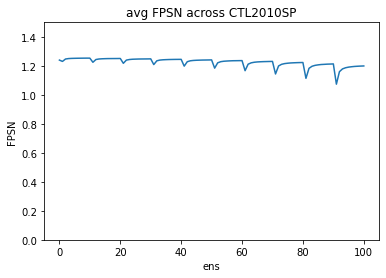

In [111]:
v='FPSN'
ds[v].mean(dim='time').plot()
plt.title('avg '+v+' across '+exp)
plt.ylim([0,1.5]);

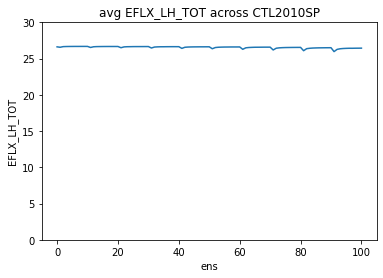

In [113]:
v='EFLX_LH_TOT'
ds[v].mean(dim='time').plot()
plt.title('avg '+v+' across '+exp)
plt.ylim([0,30]);

In [116]:
### reshape to 10x10
ix=np.arange(101)>0 #drop default
fpsn=ds.FPSN.isel(ens=ix).mean(dim='time').compute()

In [124]:
kmax=np.unique(ds.kmax.isel(ens=ix).values)
p50=np.unique(ds.psi50.isel(ens=ix).values)/101974

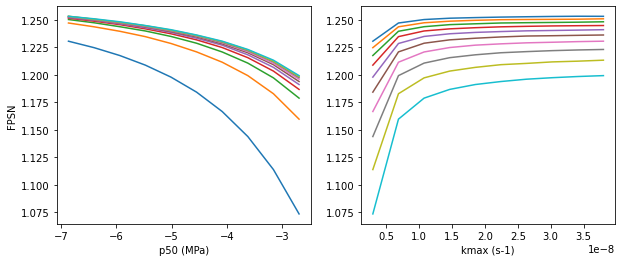

In [127]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(p50,fpsn.values.reshape([10,10]));
plt.ylabel('FPSN')
plt.xlabel('p50 (MPa)')
plt.subplot(122)
plt.plot(kmax,fpsn.values.reshape([10,10]).T)
plt.xlabel('kmax (s-1)');

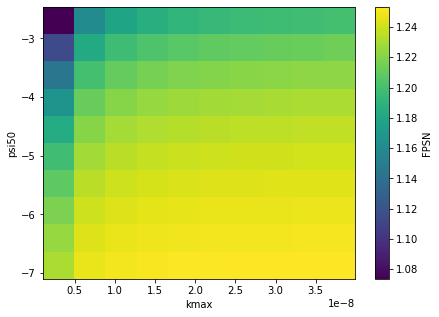

In [139]:
plt.figure(figsize=[7,5])
plt.pcolormesh(kmax,p50,fpsn.values.reshape([10,10]),shading='auto')
plt.colorbar(label='FPSN')
plt.xlabel('kmax')
plt.ylabel('psi50');

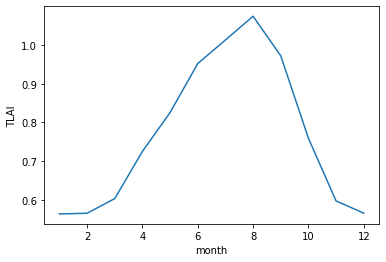

In [141]:
ds.TLAI.groupby('time.month').mean().plot()

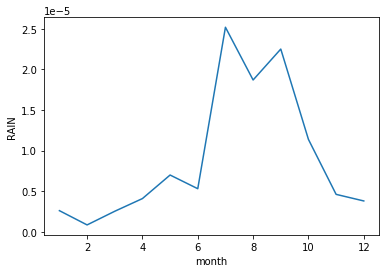

In [142]:
ds.RAIN.groupby('time.month').mean().plot()

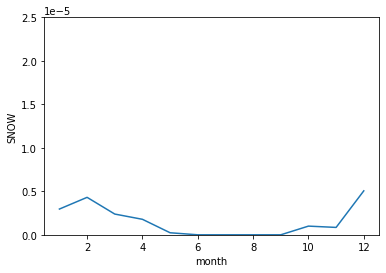

In [145]:
ds.SNOW.groupby('time.month').mean().plot()
plt.ylim([0,2.5e-5]);

In [148]:
ds2=get_ds('2xCO2SP',dvs)

In [150]:
fpsn2=ds2.FPSN.isel(ens=ix).mean(dim='time').compute()

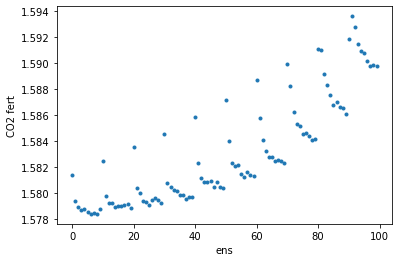

In [153]:
plt.plot(fpsn2/fpsn,'.');
plt.ylabel('CO2 fert')
plt.xlabel('ens');

In [156]:
### see all of the variables of interest
files=get_files('CTL2010SP')
tmp=xr.open_dataset(files[0])
tmp

<xarray.Dataset>
Dimensions:         (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1, time: 175345, hist_interval: 2, lndgrid: 1, levsno: 12, nvegwcs: 4)
Coordinates:
  * levgrnd         (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi          (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak          (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp         (levdcmp) float32 1.0
  * time            (time) datetime64[ns] 2008-01-01 ... 2018-01-01
Dimensions without coordinates: hist_interval, lndgrid, levsno, nvegwcs
Data variables: (12/99)
    mcdate          (time) int32 ...
    mcsec           (time) int32 ...
    mdcur           (time) int32 ...
    mscur           (time) int32 ...
    nstep           (time) int32 ...
    time_bounds     (time, hist_interval) datetime64[ns] ...
    ...              ...
    TWS             (time, lndgrid) float32 ...
    USTAR           (time, lndgrid) float32 ...
    VEGWP           (time, nvegwcs, lndgrid) float32 ...
    WIND            (time, lndgrid) float32 ...
    ZETA            (time, lndgrid) float32 ...
    num_iter        (time, lndgrid) float32 ...
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 11/10/22 17:44:07
    source:                                    Community Terrestrial Systems ...
    hostname:                                  casper
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          minute_30

In [159]:
### note that you can see long_name etc by inspecting attrs
tmp['FIRE'].attrs

{'long_name': 'emitted infrared (longwave) radiation',
 'units': 'W/m^2',
 'cell_methods': 'time: mean'}

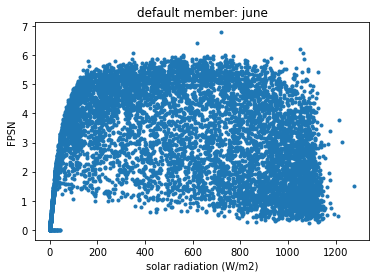

In [166]:
ix=ds['time.month']==6
plt.plot(ds.FSDS.isel(time=ix),ds.FPSN.isel(ens=0,time=ix),'.')
plt.xlabel('solar radiation (W/m2)')
plt.ylabel('FPSN')
plt.title('default member: june');